In [167]:

import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns 
import datetime as dt
from collections import Counter
from nltk.tokenize import sent_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [168]:
from google.colab import files
uploaded = files.upload()

Saving trumph_new.csv to trumph_new (6).csv


In [169]:
import io
df = pd.read_csv(io.BytesIO(uploaded['trumph_new.csv']))

In [170]:
df.head(5)

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets
0,2020-07-21 23:59:54,1285726226813014016,False,"You are amazing, @chicagosmayor. I hope you g...",rathacat,"Patterson, CA",Twitter Web App,1,2429,3710,0
1,2020-07-21 23:59:51,1285726213001093127,False,#Trump finally admitted that the spread of the...,Nor_Kan_1965,NaN,Twitter for Android,1,112,73,1
2,2020-07-21 23:59:30,1285726126820794368,False,@NavygirlLaura @GOP A sure sign the #GOP party...,ShannsolSolberg,"Texas, USA",Twitter for iPhone,1,1359,1745,0
3,2020-07-21 23:59:20,1285726083455877121,False,Why is #Trump silent when cops beat a #Veteran...,in_pubs,NJ-DC-NY-🌍,Twitter for iPhone,650,78851,17726,254
4,2020-07-21 23:58:51,1285725963024818183,False,"@gtconway3d Speaking of falling, please be car...",dfwcitizen,• GOD BLESS AMERICA •,Twitter for iPhone,2,5333,375,0


In [171]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47652 entries, 0 to 47651
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       47652 non-null  object
 1   Tweet_id   47652 non-null  int64 
 2   Verified   47652 non-null  bool  
 3   Tweet      47652 non-null  object
 4   User       47652 non-null  object
 5   Location   34414 non-null  object
 6   Source     47650 non-null  object
 7   Likes      47652 non-null  int64 
 8   Followers  47652 non-null  int64 
 9   Following  47652 non-null  int64 
 10  Retweets   47652 non-null  int64 
dtypes: bool(1), int64(5), object(5)
memory usage: 3.7+ MB


In [172]:
df.shape

(47652, 11)

# Data Preprocessing and cleaning

In [173]:
df['Date'] = df['Date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S')) #Convert to date time format

In [174]:

df.dtypes

Date         datetime64[ns]
Tweet_id              int64
Verified               bool
Tweet                object
User                 object
Location             object
Source               object
Likes                 int64
Followers             int64
Following             int64
Retweets              int64
dtype: object

In [175]:
df.isnull().sum()

Date             0
Tweet_id         0
Verified         0
Tweet            0
User             0
Location     13238
Source           2
Likes            0
Followers        0
Following        0
Retweets         0
dtype: int64

The location column has upto 13238 values as null. This may be the case since many users didn't voluntarily put it up. However this is not of much concern for our project. Hence we would leave it to null only

In [176]:
df['Source'].value_counts()

Twitter Web App        17539
Twitter for iPhone     13156
Twitter for Android    10024
Twitter for iPad        2327
TweetDeck                816
                       ...  
National Herald            1
__CryptoNews               1
TrumpTweetWeather          1
Hn_bot                     1
Stop it Bot                1
Name: Source, Length: 204, dtype: int64

In [177]:
df['Location'].nunique()

6621

In [178]:

tweets_list = df['Tweet'].tolist()
len(tweets_list)

47652

In [179]:
tweets_list_updated = set(tweets_list)
len(tweets_list_updated)

47093

In [180]:
tweets_list_updated  = list(tweets_list_updated)
type(tweets_list_updated)


list

In [108]:
df['Tweet'].duplicated().sum()


559

In [181]:

df = df.drop_duplicates(subset = 'Tweet', keep = 'first',ignore_index = True)
df.shape

(47093, 11)

In [182]:
df['Tweet'].duplicated().sum()

0

# Removing emojis

In [183]:
def remove_emoji(tweet):
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', tweet)



df['Processed_Tweet']=df.Tweet.apply(remove_emoji)


In [184]:

count = 0
for i in df['Processed_Tweet']:
    if re.match(r'^RT', i):  #remove any rows that contain RT
        df.drop(df.loc[df['Processed_Tweet']==i].index,inplace = True)
        count+=1
    
count

1

In [185]:

df.shape

(47092, 12)

In [186]:
df['Processed_Tweet']

0        You are amazing, @chicagosmayor.  I hope you g...
1        #Trump finally admitted that the spread of the...
2        @NavygirlLaura @GOP A sure sign the #GOP party...
3        Why is #Trump silent when cops beat a #Veteran...
4        @gtconway3d Speaking of falling, please be car...
                               ...                        
47088    Looks like #BorisJohnson is pandering to #Trum...
47089    This is what the US map MUST look like on NOVE...
47090    @thehill Death-count 7/14 in countries that to...
47091    To be human, one has to possess empathy and mo...
47092    Douglas London, a former CIA senior operations...
Name: Processed_Tweet, Length: 47092, dtype: object


# Remove Retweets

In [187]:
df['Processed_Tweet'] = [re.sub('^RT[\s]','',i) for i in df['Processed_Tweet']]  #Remove RT substring

In [188]:
df['Processed_Tweet']

0        You are amazing, @chicagosmayor.  I hope you g...
1        #Trump finally admitted that the spread of the...
2        @NavygirlLaura @GOP A sure sign the #GOP party...
3        Why is #Trump silent when cops beat a #Veteran...
4        @gtconway3d Speaking of falling, please be car...
                               ...                        
47088    Looks like #BorisJohnson is pandering to #Trum...
47089    This is what the US map MUST look like on NOVE...
47090    @thehill Death-count 7/14 in countries that to...
47091    To be human, one has to possess empathy and mo...
47092    Douglas London, a former CIA senior operations...
Name: Processed_Tweet, Length: 47092, dtype: object


# Remove Usernames

In [189]:
df['Processed_Tweet'] = [re.sub('@[^\s]+', ' ', i) for i in df['Processed_Tweet']] #remove usernames

In [190]:

df['Processed_Tweet']

0        You are amazing,    I hope you get all the sup...
1        #Trump finally admitted that the spread of the...
2            A sure sign the #GOP party is breaking apa...
3        Why is #Trump silent when cops beat a #Veteran...
4          Speaking of falling, please be careful climb...
                               ...                        
47088    Looks like #BorisJohnson is pandering to #Trum...
47089    This is what the US map MUST look like on NOVE...
47090      Death-count 7/14 in countries that took prom...
47091    To be human, one has to possess empathy and mo...
47092    Douglas London, a former CIA senior operations...
Name: Processed_Tweet, Length: 47092, dtype: object

In [191]:
df['Processed_Tweet'] = [re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', i) for i in df['Processed_Tweet']] #Remove urls

In [192]:
df['Processed_Tweet'] = [re.sub(r'#([^\s]+)', r'\1', i) for i in df['Processed_Tweet']] # remove the # in #hashtag

In [193]:
!pip install tweet-preprocessor


In [194]:
import preprocessor.api as p
df['Processed_Tweet'] = [p.clean(i) for i in df['Processed_Tweet']]

In [195]:

df['Processed_Tweet']

0        You are amazing, I hope you get all the suppor...
1        Trump finally admitted that the spread of the ...
2        A sure sign the GOP party is breaking apart is...
3        Why is Trump silent when cops beat a Veteran a...
4        Speaking of falling, please be careful climbin...
                               ...                        
47088    Looks like BorisJohnson is pandering to Trump ...
47089    This is what the US map MUST look like on NOVE...
47090    Death-count /14 in countries that took prompt ...
47091    To be human, one has to possess empathy and mo...
47092    Douglas London, a former CIA senior operations...
Name: Processed_Tweet, Length: 47092, dtype: object


# Removing Any Special Characters, Numbers, Punctuations etc.

In [196]:
#removing unnecessary special characters, numbers, punctuations in tweets
df.Processed_Tweet = df.Processed_Tweet.str.replace("[^a-zA-Z]", " ")
df.Processed_Tweet = [low.lower() for low in df.Processed_Tweet] #Converting into lower case
df.Processed_Tweet =  df.Processed_Tweet.str.replace("amp", "")

In [197]:
df['Processed_Tweet'][40] #Sample tweet

'it wasnt just hitlerit isnt just trumpboth these men were enabled by their societies  the chilling reality '


# EDA

In [198]:
df['User'].value_counts()

FOREXEAASSARV10    453
Hotpage_News       307
robinsnewswire     304
Haidji             181
TweetyThings1      164
                  ... 
mydemocracy          1
FredericEsq          1
NinjaWateCowboy      1
taunya_durant        1
godfatherofchao      1
Name: User, Length: 18123, dtype: int64

In [199]:
df.query('User == "FOREXEAASSARV10"').Processed_Tweet.tolist()

['ex laguna beach officer held gun to colleague s head after bar hopping  prosecutors say click the link plandemic news trump nwo wakeup covid   covidiots covid   coronavirus breakingnews breaking',
 'pilot truck stop empire moves away from family leadership click the link plandemic news trump nwo wakeup covid   covidiots covid   coronavirus breakingnews breaking',
 'nasdaq takes a turn to new session lows click the link plandemic news trump nwo wakeup covid   covidiots covid   coronavirus breakingnews breaking',
 'little noticed  filipino americans are dying of covid    at an alarming rate click the link plandemic news trump nwo wakeup covid   covidiots covid   coronavirus breakingnews breaking',
 'apple pledges to be carbon neutral by click the link plandemic news trump nwo wakeup covid   covidiots covid   coronavirus breakingnews breaking',
 'eur gbp price forecast  eurgbp tests key psychological level click the link plandemic news trump nwo wakeup covid   covidiots covid   coronavi

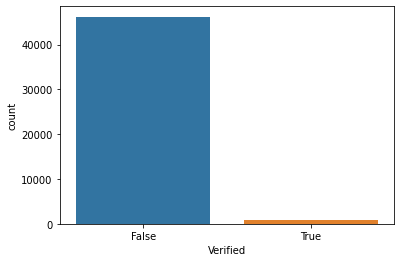

In [200]:
bar = sns.countplot(df['Verified'])

In [201]:
df['Verified'].value_counts()

False    46230
True       862
Name: Verified, dtype: int64

In [202]:
df_verified = df.query('Verified == True')

In [203]:

df_verified['User'].value_counts()

Cairo67Unedited    43
AndyOstroy         38
alana_austin       27
DeeTwoCents        24
Rasmussen_Poll     21
                   ..
hotpress            1
KLTV7               1
PISM_Poland         1
bhairavigoswami     1
petermaer           1
Name: User, Length: 323, dtype: int64

In [204]:
df_verified.query('User == "Cairo67Unedited"').Processed_Tweet.tolist()

['well that didn t take long press conference where trump said maskupwas minutes ago new scandal trumps request of an ambassador  get the british open for me',
 'trump says   virus will get worse before it gets better now more than u s  military members have contracted the virus  and the infection rate in the armed services has tripled over the past six weeks ',
 'ignorance can kill and trump politicized this pandemicthe result today there is an r next to of top statesr florida d california r texas r arizona    r georgia r tennessee     r south carolina     r oklahoma     r louisiana     r mississippi     ',
 'someone in trump  s inner circle got to trump  convinced  if you don t change the narrative on covid   you will definitely lose in november i suspected it when he announced the presser today and after this show it is a certaintyhe said  it will get worse before it gets better ',
 'trump comm director tim murtaugh thought  incorrectly  he could bully the brilliant with one lying t

In [205]:
df_verified.query('User == "AndyOstroy"').Processed_Tweet.tolist()

['to everyone wanking off right now to trump s big  pivot  today of  embracing  masks and distancing   please don t make me rub it in your face tomorrow when he returns to being a mask mocking sociopath    covid   coronavirus',
 'republicans  definition of trump derangement syndrome january   he s living rent free in libtards  heads  now   good lord   he s gonna cost us the white house and the senate    ',
 'this might be a tad psychological  but if we re ever to truly understand trump s deranged pathology we ll need to understand why he wishes unconscionably corrupt evil people like ghislainemaxwell  well    ',
 'so  in stunningly meaningless minutes from we learn that covid   s gonna get worse before it gets better    and that he carries a mask in his pocket  do coronavirus droplets spread through cheap  s suits  trump',
 ' trump just said twice about global child sex trafficker ghislainemaxwell   i wish her well    ',
 'wrote this years ago  not such a stretch now  is it     trump c

In [206]:
days = df['Date'].dt.day.tolist()

In [207]:
no_of_days = Counter(days)
no_of_days

Counter({14: 5786, 15: 10238, 17: 7564, 18: 7850, 20: 5509, 21: 10145})

Text(0.5, 1.0, 'Count Of Extracted Tweets On Each Day')

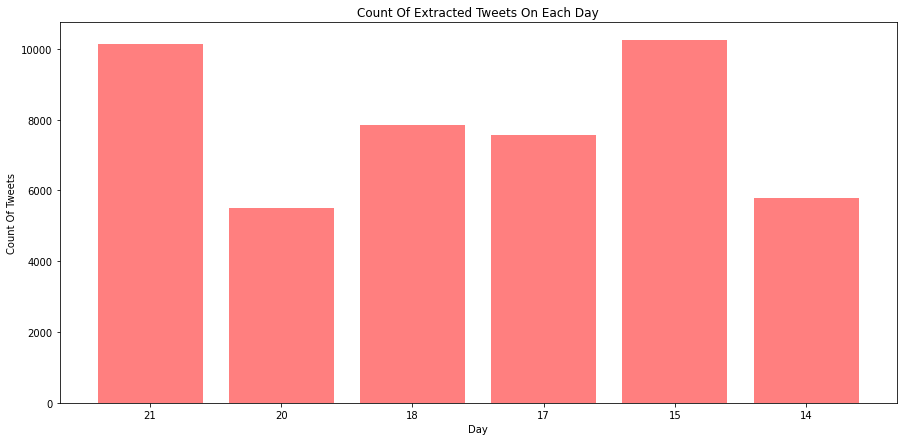

In [208]:
fig = plt.figure(figsize = (15,7))
plt.bar(range(len(no_of_days)), list(no_of_days.values()), align='center', alpha = 0.5,color = 'red')
plt.xticks(range(len(no_of_days)), list(no_of_days.keys()))
plt.xlabel("Day")
plt.ylabel("Count Of Tweets")
plt.title("Count Of Extracted Tweets On Each Day")

In [209]:
hours = df['Date'].dt.hour.tolist()

In [210]:

no_of_hours = Counter(hours)
no_of_hours

Counter({0: 1385,
         1: 1485,
         2: 1578,
         3: 1456,
         4: 1090,
         5: 936,
         6: 816,
         7: 695,
         8: 630,
         9: 706,
         10: 831,
         11: 1238,
         12: 1636,
         13: 2477,
         14: 2943,
         15: 2785,
         16: 2799,
         17: 2860,
         18: 2684,
         19: 2727,
         20: 2952,
         21: 3937,
         22: 3587,
         23: 2859})

Text(0.5, 1.0, 'Count Of Extracted Tweets On Each Hour')

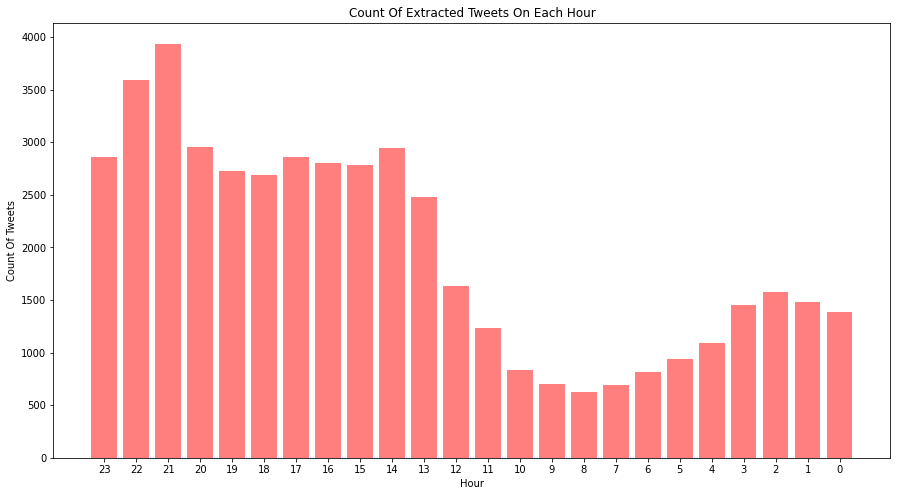

In [211]:
fig = plt.figure(figsize = (15,8))
plt.bar(range(len(no_of_hours)), list(no_of_hours.values()), align='center', alpha = 0.5,color = 'red')
plt.xticks(range(len(no_of_hours)), list(no_of_hours.keys()))
plt.xlabel("Hour")
plt.ylabel("Count Of Tweets")
plt.title("Count Of Extracted Tweets On Each Hour")

In [212]:
from wordcloud import WordCloud
tokenizer = TweetTokenizer()

In [213]:
import nltk
nltk.download('stopwords')
from nltk.corpus import words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 
stop_words = list(stop_words)
print(stop_words) #remove stop words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['him', 'me', 'each', 'theirs', 'same', 'yours', 'between', "weren't", 'with', 'against', 'now', 'whom', 'himself', "shan't", 'yourselves', 'their', 'will', 'did', 'further', 'its', "should've", 'been', 'have', 'or', "it's", 'just', 'below', 'has', 'as', 'when', 'that', 'hadn', 'i', 'his', 'll', 'her', 'on', 'm', 'shouldn', 'over', 'how', 'should', 'then', 'can', 'once', 'needn', "needn't", 'too', 'doesn', 'up', "shouldn't", 'itself', 'what', "couldn't", 'into', 'am', 'being', 'because', 'some', "wasn't", "hadn't", 'out', 's', 'all', 'our', "didn't", "doesn't", 'weren', 'myself', 'which', 'both', "isn't", 'this', 'while', 'at', 'no', 'most', 'an', 'off', 'aren', 'them', 'but', 'he', 'only', 'these', "you'd", 'after', 'from', "aren't", 'ma', 'mightn', 'where', 'wasn', 'didn', 'having', 'such', 'herself', 'they', 'and', 'are', 'about', 'ourselves', 'wouldn', 'those', 'wh

In [214]:
df['Processed_Tweet'] = df.Processed_Tweet.apply(lambda x: ' '.join(w for w in x.split() if w not in stop_words))   #Remove stopwords




In [215]:
df['Processed_Tweet'] = df['Processed_Tweet'].apply(lambda x: tokenizer.tokenize(x)) #tokenize

In [216]:
#Perform stemming 
def lemmatize_stemming(text):
    stemmer=PorterStemmer()
    return stemmer.stem(text)

In [217]:
df['Processed_Tweet'] = df['Processed_Tweet'].apply(lambda x: [lemmatize_stemming(i) for i in x]) # stemming

In [218]:
df['Processed_Tweet']

0        [amaz, hope, get, support, need, resist, trump...
1        [trump, final, admit, spread, coronaviru, get,...
2        [sure, sign, gop, parti, break, apart, start, ...
3        [trump, silent, cop, beat, veteran, put, hospi...
4        [speak, fall, pleas, care, climb, chairthos, p...
                               ...                        
47088    [look, like, borisjohnson, pander, trump, read...
47089    [us, map, must, look, like, novemb, rd, like, ...
47090    [death, count, countri, took, prompt, aggress,...
47091    [human, one, possess, empathi, moral, daniel, ...
47092    [dougla, london, former, cia, senior, oper, of...
Name: Processed_Tweet, Length: 47092, dtype: object

In [219]:
df['Processed_Tweet'] = df.Processed_Tweet.apply(lambda x: [i for i in x if len(i)>2])

In [220]:
df

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet
0,2020-07-21 23:59:54,1285726226813014016,False,"You are amazing, @chicagosmayor. I hope you g...",rathacat,"Patterson, CA",Twitter Web App,1,2429,3710,0,"[amaz, hope, get, support, need, resist, trump..."
1,2020-07-21 23:59:51,1285726213001093127,False,#Trump finally admitted that the spread of the...,Nor_Kan_1965,NaN,Twitter for Android,1,112,73,1,"[trump, final, admit, spread, coronaviru, get,..."
2,2020-07-21 23:59:30,1285726126820794368,False,@NavygirlLaura @GOP A sure sign the #GOP party...,ShannsolSolberg,"Texas, USA",Twitter for iPhone,1,1359,1745,0,"[sure, sign, gop, parti, break, apart, start, ..."
3,2020-07-21 23:59:20,1285726083455877121,False,Why is #Trump silent when cops beat a #Veteran...,in_pubs,NJ-DC-NY-🌍,Twitter for iPhone,650,78851,17726,254,"[trump, silent, cop, beat, veteran, put, hospi..."
4,2020-07-21 23:58:51,1285725963024818183,False,"@gtconway3d Speaking of falling, please be car...",dfwcitizen,• GOD BLESS AMERICA •,Twitter for iPhone,2,5333,375,0,"[speak, fall, pleas, care, climb, chairthos, p..."
...,...,...,...,...,...,...,...,...,...,...,...,...
47088,2020-07-14 13:00:29,1283023564157923330,False,Looks like #BorisJohnson is pandering to #Trum...,BananaaAlana,"Salford, England",Twitter for iPhone,0,804,1447,0,"[look, like, borisjohnson, pander, trump, read..."
47089,2020-07-14 13:00:28,1283023556855705600,False,This is what the US map MUST look like on NOVE...,Deleno12,America 🇺🇸🇺🇸,Hypefury,4,493,226,3,"[map, must, look, like, novemb, like, agre, vo..."
47090,2020-07-14 13:00:24,1283023541496156162,False,@thehill Death-count 7/14 in countries that to...,tomfervoy,"New York, NY",Twitter for iPhone,10,442,1085,7,"[death, count, countri, took, prompt, aggress,..."
47091,2020-07-14 13:00:20,1283023527164227584,False,"To be human, one has to possess empathy and mo...",CFaurholt,"San Diego, CA",Twitter Web App,0,125,774,0,"[human, one, possess, empathi, moral, daniel, ..."


In [222]:

texts = []
texts = df.Processed_Tweet.apply(lambda x: [i for i in x] )

In [223]:

all_words = []
for i in texts:
    all_words.append(" ".join(i))

In [224]:
text = []
for i in texts:
    for j in i:
        text.append(j)

In [225]:
len(text)

699193

In [226]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(' '.join(text))

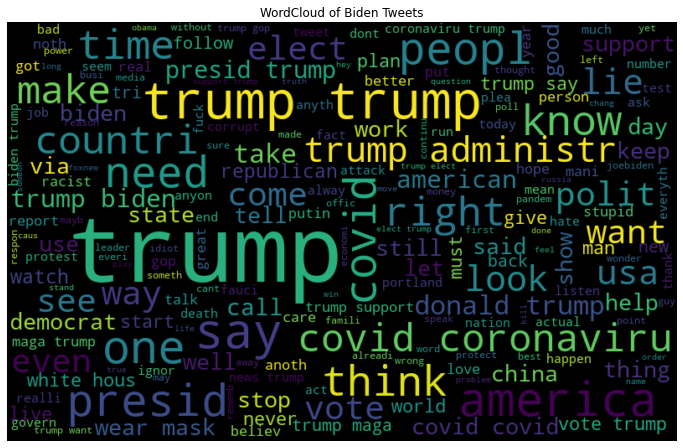

In [227]:
plt.figure(figsize = (12, 12), facecolor="None") 
plt.imshow(wordcloud,interpolation='bilinear') 
plt.axis("off") 
plt.title("WordCloud of Biden Tweets")
plt.show()

Word clouds, created by words corresponding to maximum frequency within the twitter data stream help in identifying keywords and trends.

# Sentiment Analysis

In [228]:
from textblob import TextBlob

In [229]:
pol=[]
for Tweet in all_words:
    blob = TextBlob(Tweet)
    pol.append(blob.sentiment.polarity)

In [230]:

len(pol)

47092

In [231]:
len(text)

699193

In [232]:
df['Processed_Tweet']

0        [amaz, hope, get, support, need, resist, trump...
1        [trump, final, admit, spread, coronaviru, get,...
2        [sure, sign, gop, parti, break, apart, start, ...
3        [trump, silent, cop, beat, veteran, put, hospi...
4        [speak, fall, pleas, care, climb, chairthos, p...
                               ...                        
47088    [look, like, borisjohnson, pander, trump, read...
47089    [map, must, look, like, novemb, like, agre, vo...
47090    [death, count, countri, took, prompt, aggress,...
47091    [human, one, possess, empathi, moral, daniel, ...
47092    [dougla, london, former, cia, senior, oper, of...
Name: Processed_Tweet, Length: 47092, dtype: object

In [233]:

positive=0
negative=0
neutral=0
for i in pol:
    if i>0:
        positive+=1
    elif i<0:
        negative+=1
    else:
        neutral+=1
print("Positive Tweets:",positive)
print("Negative Tweets:",negative)
print("Neutral Tweets",neutral)

Positive Tweets: 16025
Negative Tweets: 11315
Neutral Tweets 19752


In [234]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [235]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
sentiment_scores= []
for i in all_words:
    sentiment_scores.append([sid.polarity_scores(i)])
#sentimental_score = pd.DataFrame(list(sentiment_scores))
#sentimental_score.tail(12)

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [236]:
value = []
for i in sentiment_scores:
    for dict1 in i:
        value.append(list(dict1.values()))

In [237]:

sentimental_score_df = pd.DataFrame(data = value, columns = ['Negative','Neutral','Positive','Compound'])
sentimental_score_df

,Negative,Neutral,Positive,Compound
0,0.000,0.641,0.359,0.6808
1,0.000,0.699,0.301,0.7096
2,0.168,0.721,0.111,-0.2960
3,0.101,0.754,0.146,0.2263
4,0.000,0.833,0.167,0.4939
...,...,...,...,...
47087,0.000,0.828,0.172,0.3612
47088,0.000,0.706,0.294,0.6124
47089,0.372,0.525,0.102,-0.8957
47090,0.000,1.000,0.000,0.0000


In [238]:
sentimental_score_df['val'] = sentimental_score_df['Compound'].apply(lambda x: 'Neutral' if x == 0 else ('Positive' if x > 0 else 'Negative'))
sentimental_score_df.head()

,Negative,Neutral,Positive,Compound,val
0,0.000,0.641,0.359,0.6808,Positive
1,0.000,0.699,0.301,0.7096,Positive
2,0.168,0.721,0.111,-0.2960,Negative
3,0.101,0.754,0.146,0.2263,Positive
4,0.000,0.833,0.167,0.4939,Positive


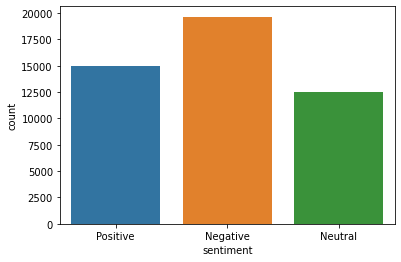

In [239]:
sent_count = pd.DataFrame.from_dict(Counter(sentimental_score_df['val']), orient = 'index').reset_index()
sent_count.columns = ['sentiment', 'count']

sns.barplot(y="count", x='sentiment', data=sent_count)

In [245]:
filepath = r"/content/NRC Emotion Lexicon.txt"
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=45, sep='\t')
emolex_df.head(12)
len(emolex_df)

86343

In [246]:

emotions={'positive':0, 'negative':0, 'surprise':0,'sadness':0,
          'anger':0,'joy':0,'negative':0,'trust':0,'fear':0,'anticipation':0,'disgust':0}

In [248]:
word_emotion=dict()
for i in range(0,86343):
    emotion=emolex_df['emotion'][i]
    word=emolex_df['word'][i]
    association=emolex_df['association'][i]
    
    if word not in word_emotion:
        word_emotion[word]=dict()
    word_emotion[word][emotion]=association

In [320]:
for i in range(0,21506):
    text=df['Tweet'][i]
    for j in text.split():
        if j in word_emotion:
            for k in word_emotion[j]:
                emotions[k]+=word_emotion[j][k]

In [321]:
emotions

{'anger': 27198.0,
 'anticipation': 17742.0,
 'disgust': 17823.0,
 'fear': 29994.0,
 'joy': 14913.0,
 'negative': 50823.0,
 'positive': 41526.0,
 'sadness': 23355.0,
 'surprise': 12444.0,
 'trust': 26478.0}

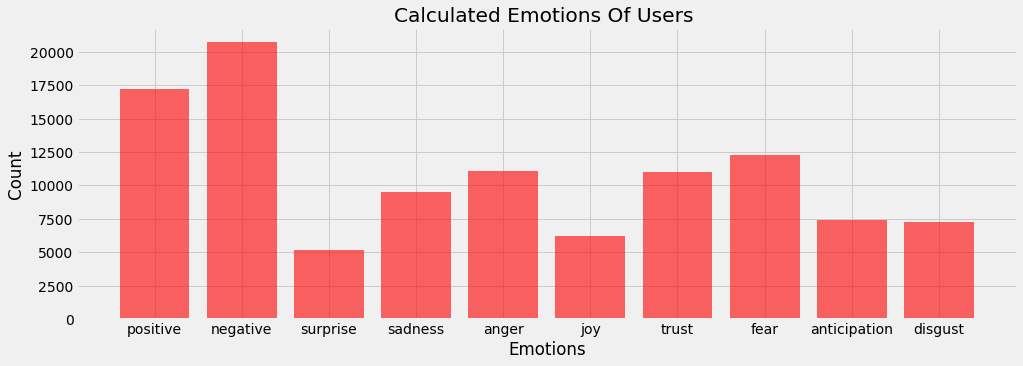

In [254]:

plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [15,5]
plt.bar(list(emotions.keys()),list(emotions.values()),color='red',alpha = 0.6)
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Calculated Emotions Of Users ')
plt.show()

In [322]:
df.Location  = df.Location.fillna('USA')

In [256]:

f = [i for i in df['Location'] if type(i) != str]
f

[]

In [324]:
df.Location = df.Location.apply(lambda x: x.replace('United States','USA'))

In [325]:

df.Location.value_counts()

USA                               15357
California, USA                     877
Washington, DC                      633
Los Angeles, CA                     385
New York, NY                        305
                                  ...  
us                                    1
Houston, Texas                        1
Bellflower Ca                         1
Gananoque/1000 Islands, ON CAN        1
New York , NY                         1
Name: Location, Length: 6613, dtype: int64

In [326]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [327]:

locations = []
locations_1 = []

locations = [i.split(',')[-1] for i in df['Location']]
locations_1 =  [i.split(',')[0] for i in df['Location']]
df['Processed_Location'] = locations_1
df

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet,Processed_Location,sentiment,day,sentiment_1
0,2020-07-21 23:59:54,1285726226813014016,False,"You are amazing, @chicagosmayor. I hope you g...",rathacat,"Patterson, CA",Twitter Web App,1,2429,3710,0,"[amaz, hope, get, support, need, resist, trump...",Patterson,Positive,21,2
1,2020-07-21 23:59:51,1285726213001093127,False,#Trump finally admitted that the spread of the...,Nor_Kan_1965,USA,Twitter for Android,1,112,73,1,"[trump, final, admit, spread, coronaviru, get,...",USA,Positive,21,2
2,2020-07-21 23:59:30,1285726126820794368,False,@NavygirlLaura @GOP A sure sign the #GOP party...,ShannsolSolberg,"Texas, USA",Twitter for iPhone,1,1359,1745,0,"[sure, sign, gop, parti, break, apart, start, ...",Texas,Negative,21,0
3,2020-07-21 23:59:20,1285726083455877121,False,Why is #Trump silent when cops beat a #Veteran...,in_pubs,NJ-DC-NY-🌍,Twitter for iPhone,650,78851,17726,254,"[trump, silent, cop, beat, veteran, put, hospi...",NJ-DC-NY-🌍,Positive,21,2
4,2020-07-21 23:58:51,1285725963024818183,False,"@gtconway3d Speaking of falling, please be car...",dfwcitizen,• GOD BLESS AMERICA •,Twitter for iPhone,2,5333,375,0,"[speak, fall, pleas, care, climb, chairthos, p...",• GOD BLESS AMERICA •,Positive,21,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47088,2020-07-14 13:00:29,1283023564157923330,False,Looks like #BorisJohnson is pandering to #Trum...,BananaaAlana,"Salford, England",Twitter for iPhone,0,804,1447,0,"[look, like, borisjohnson, pander, trump, read...",Salford,Positive,14,2
47089,2020-07-14 13:00:28,1283023556855705600,False,This is what the US map MUST look like on NOVE...,Deleno12,America 🇺🇸🇺🇸,Hypefury,4,493,226,3,"[map, must, look, like, novemb, like, agre, vo...",America 🇺🇸🇺🇸,Negative,14,0
47090,2020-07-14 13:00:24,1283023541496156162,False,@thehill Death-count 7/14 in countries that to...,tomfervoy,"New York, NY",Twitter for iPhone,10,442,1085,7,"[death, count, countri, took, prompt, aggress,...",New York,Neutral,14,1
47091,2020-07-14 13:00:20,1283023527164227584,False,"To be human, one has to possess empathy and mo...",CFaurholt,"San Diego, CA",Twitter Web App,0,125,774,0,"[human, one, possess, empathi, moral, daniel, ...",San Diego,Neutral,14,1


In [328]:
df1 = df

In [329]:
df1['sentiment'] = sentimental_score_df['val']



In [330]:
df1.head()

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet,Processed_Location,sentiment,day,sentiment_1
0,2020-07-21 23:59:54,1285726226813014016,False,"You are amazing, @chicagosmayor. I hope you g...",rathacat,"Patterson, CA",Twitter Web App,1,2429,3710,0,"[amaz, hope, get, support, need, resist, trump...",Patterson,Positive,21,2
1,2020-07-21 23:59:51,1285726213001093127,False,#Trump finally admitted that the spread of the...,Nor_Kan_1965,USA,Twitter for Android,1,112,73,1,"[trump, final, admit, spread, coronaviru, get,...",USA,Positive,21,2
2,2020-07-21 23:59:30,1285726126820794368,False,@NavygirlLaura @GOP A sure sign the #GOP party...,ShannsolSolberg,"Texas, USA",Twitter for iPhone,1,1359,1745,0,"[sure, sign, gop, parti, break, apart, start, ...",Texas,Negative,21,0
3,2020-07-21 23:59:20,1285726083455877121,False,Why is #Trump silent when cops beat a #Veteran...,in_pubs,NJ-DC-NY-🌍,Twitter for iPhone,650,78851,17726,254,"[trump, silent, cop, beat, veteran, put, hospi...",NJ-DC-NY-🌍,Positive,21,2
4,2020-07-21 23:58:51,1285725963024818183,False,"@gtconway3d Speaking of falling, please be car...",dfwcitizen,• GOD BLESS AMERICA •,Twitter for iPhone,2,5333,375,0,"[speak, fall, pleas, care, climb, chairthos, p...",• GOD BLESS AMERICA •,Positive,21,2


In [331]:
df1.to_csv('Location.csv',index = False)

In [332]:

df1['day'] = df.Date.dt.day
df1.head()

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet,Processed_Location,sentiment,day,sentiment_1
0,2020-07-21 23:59:54,1285726226813014016,False,"You are amazing, @chicagosmayor. I hope you g...",rathacat,"Patterson, CA",Twitter Web App,1,2429,3710,0,"[amaz, hope, get, support, need, resist, trump...",Patterson,Positive,21,2
1,2020-07-21 23:59:51,1285726213001093127,False,#Trump finally admitted that the spread of the...,Nor_Kan_1965,USA,Twitter for Android,1,112,73,1,"[trump, final, admit, spread, coronaviru, get,...",USA,Positive,21,2
2,2020-07-21 23:59:30,1285726126820794368,False,@NavygirlLaura @GOP A sure sign the #GOP party...,ShannsolSolberg,"Texas, USA",Twitter for iPhone,1,1359,1745,0,"[sure, sign, gop, parti, break, apart, start, ...",Texas,Negative,21,0
3,2020-07-21 23:59:20,1285726083455877121,False,Why is #Trump silent when cops beat a #Veteran...,in_pubs,NJ-DC-NY-🌍,Twitter for iPhone,650,78851,17726,254,"[trump, silent, cop, beat, veteran, put, hospi...",NJ-DC-NY-🌍,Positive,21,2
4,2020-07-21 23:58:51,1285725963024818183,False,"@gtconway3d Speaking of falling, please be car...",dfwcitizen,• GOD BLESS AMERICA •,Twitter for iPhone,2,5333,375,0,"[speak, fall, pleas, care, climb, chairthos, p...",• GOD BLESS AMERICA •,Positive,21,2


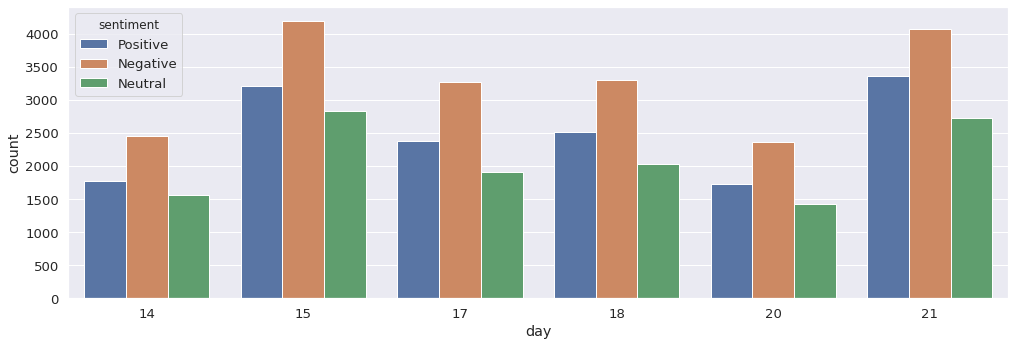

In [333]:
sns.countplot(df['day'],hue = df['sentiment'])

In [334]:
le = LabelEncoder()  


In [335]:
df1['sentiment'] = df1['sentiment'] .astype(str)

In [336]:
df1['sentiment_1']= le.fit_transform(df1['sentiment'])

In [337]:
Df2 = df1.query('sentiment_1 != 3')

In [338]:
df1

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet,Processed_Location,sentiment,day,sentiment_1
0,2020-07-21 23:59:54,1285726226813014016,False,"You are amazing, @chicagosmayor. I hope you g...",rathacat,"Patterson, CA",Twitter Web App,1,2429,3710,0,"[amaz, hope, get, support, need, resist, trump...",Patterson,Positive,21,2
1,2020-07-21 23:59:51,1285726213001093127,False,#Trump finally admitted that the spread of the...,Nor_Kan_1965,USA,Twitter for Android,1,112,73,1,"[trump, final, admit, spread, coronaviru, get,...",USA,Positive,21,2
2,2020-07-21 23:59:30,1285726126820794368,False,@NavygirlLaura @GOP A sure sign the #GOP party...,ShannsolSolberg,"Texas, USA",Twitter for iPhone,1,1359,1745,0,"[sure, sign, gop, parti, break, apart, start, ...",Texas,Negative,21,0
3,2020-07-21 23:59:20,1285726083455877121,False,Why is #Trump silent when cops beat a #Veteran...,in_pubs,NJ-DC-NY-🌍,Twitter for iPhone,650,78851,17726,254,"[trump, silent, cop, beat, veteran, put, hospi...",NJ-DC-NY-🌍,Positive,21,2
4,2020-07-21 23:58:51,1285725963024818183,False,"@gtconway3d Speaking of falling, please be car...",dfwcitizen,• GOD BLESS AMERICA •,Twitter for iPhone,2,5333,375,0,"[speak, fall, pleas, care, climb, chairthos, p...",• GOD BLESS AMERICA •,Positive,21,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47088,2020-07-14 13:00:29,1283023564157923330,False,Looks like #BorisJohnson is pandering to #Trum...,BananaaAlana,"Salford, England",Twitter for iPhone,0,804,1447,0,"[look, like, borisjohnson, pander, trump, read...",Salford,Positive,14,2
47089,2020-07-14 13:00:28,1283023556855705600,False,This is what the US map MUST look like on NOVE...,Deleno12,America 🇺🇸🇺🇸,Hypefury,4,493,226,3,"[map, must, look, like, novemb, like, agre, vo...",America 🇺🇸🇺🇸,Negative,14,0
47090,2020-07-14 13:00:24,1283023541496156162,False,@thehill Death-count 7/14 in countries that to...,tomfervoy,"New York, NY",Twitter for iPhone,10,442,1085,7,"[death, count, countri, took, prompt, aggress,...",New York,Neutral,14,1
47091,2020-07-14 13:00:20,1283023527164227584,False,"To be human, one has to possess empathy and mo...",CFaurholt,"San Diego, CA",Twitter Web App,0,125,774,0,"[human, one, possess, empathi, moral, daniel, ...",San Diego,Neutral,14,1


In [339]:
df1.sentiment.isnull().sum()

0